In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [4]:
# Update path if needed
DATA_PATH = "C:/Users/Saiesh Gaikar/Downloads/archive/Ahmedabad solar irradiance.csv"

df = pd.read_csv(DATA_PATH)


In [8]:
# Create datetime column from YEAR, MO, DY, HR
df['datetime'] = pd.to_datetime(
    df[['YEAR', 'MO', 'DY', 'HR']].rename(
        columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}
    )
)

# Sort and set datetime as index
df = df.sort_values('datetime')
df.set_index('datetime', inplace=True)

print(df.head())


                     YEAR  MO  DY  HR  ALLSKY_SFC_SW_DWN   SZA  \
datetime                                                         
2023-06-01 00:00:00  2023   6   1   0                0.0  90.0   
2023-06-01 01:00:00  2023   6   1   1                0.0  90.0   
2023-06-01 02:00:00  2023   6   1   2                0.0  90.0   
2023-06-01 03:00:00  2023   6   1   3                0.0  90.0   
2023-06-01 04:00:00  2023   6   1   4                0.0  90.0   

                     ALLSKY_SFC_UVA  ALLSKY_SFC_UVB  ALLSKY_SFC_UV_INDEX  \
datetime                                                                   
2023-06-01 00:00:00             0.0             0.0                  0.0   
2023-06-01 01:00:00             0.0             0.0                  0.0   
2023-06-01 02:00:00             0.0             0.0                  0.0   
2023-06-01 03:00:00             0.0             0.0                  0.0   
2023-06-01 04:00:00             0.0             0.0                  0.0   

    

In [9]:
# Convert hourly irradiance to daily solar energy
daily_energy = df['ALLSKY_SFC_SW_DWN'].resample('D').sum()

daily_energy = daily_energy.to_frame(name='daily_solar_energy')

print(daily_energy.head())


            daily_solar_energy
datetime                      
2023-06-01             7221.92
2023-06-02             5934.18
2023-06-03             6557.72
2023-06-04             6393.56
2023-06-05             7505.55


In [11]:
import numpy as np

# Replace NASA POWER missing value code with NaN
df[df == -999] = np.nan

# Confirm no -999 values remain
print((df == -999).sum().sum())


0


In [12]:
daily_energy = df['ALLSKY_SFC_SW_DWN'].resample('D').sum(min_count=1)
daily_energy = daily_energy.to_frame(name='daily_solar_energy')

print(daily_energy.head())


            daily_solar_energy
datetime                      
2023-06-01             7221.92
2023-06-02             5934.18
2023-06-03             6557.72
2023-06-04             6393.56
2023-06-05             7505.55


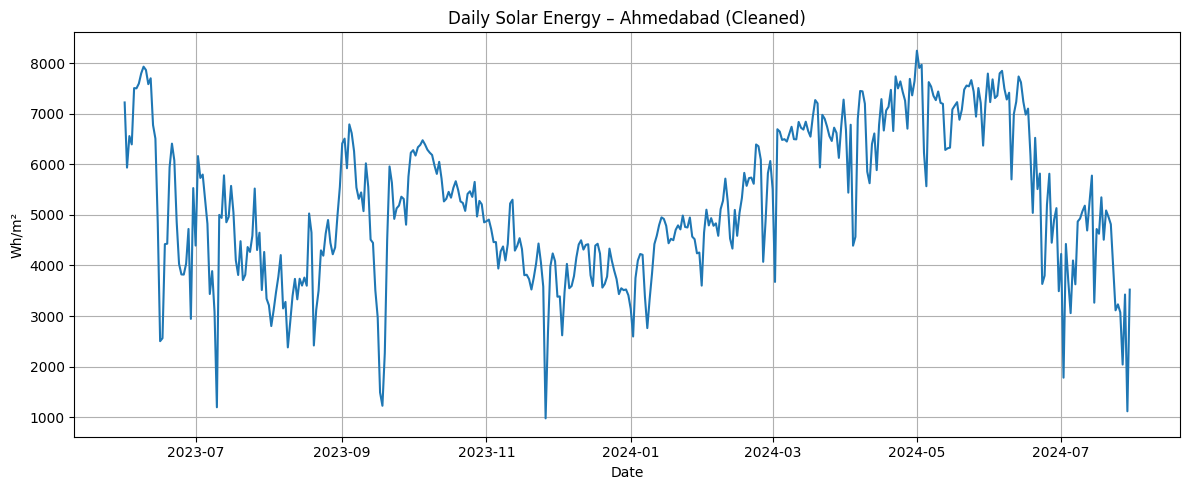

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_energy.index, daily_energy['daily_solar_energy'])
plt.title("Daily Solar Energy – Ahmedabad (Cleaned)")
plt.xlabel("Date")
plt.ylabel("Wh/m²")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Final train-test split (time-aware)
train_size = int(len(daily_energy) * 0.85)

train = daily_energy.iloc[:train_size]['daily_solar_energy']
test = daily_energy.iloc[train_size:]['daily_solar_energy']

print("Train period:", train.index.min(), "to", train.index.max())
print("Test period :", test.index.min(), "to", test.index.max())
print("Train size:", len(train))
print("Test size :", len(test))


Train period: 2023-06-01 00:00:00 to 2025-02-11 00:00:00
Test period : 2025-02-12 00:00:00 to 2025-06-01 00:00:00
Train size: 622
Test size : 110


In [23]:
# Naive baseline: yesterday predicts today (numpy-based, no index issues)
y_test = test.values

baseline_pred = y_test[:-1]
baseline_actual = y_test[1:]

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

baseline_mae = mean_absolute_error(baseline_actual, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(baseline_actual, baseline_pred))

print("Baseline MAE :", baseline_mae)
print("Baseline RMSE:", baseline_rmse)


Baseline MAE : 0.0
Baseline RMSE: 0.0


In [24]:
# Seasonal naive baseline: value from 7 days ago
y_test = test.values

baseline_pred = y_test[:-7]
baseline_actual = y_test[7:]

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

baseline_mae = mean_absolute_error(baseline_actual, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(baseline_actual, baseline_pred))

print("Seasonal Baseline MAE :", baseline_mae)
print("Seasonal Baseline RMSE:", baseline_rmse)


Seasonal Baseline MAE : 0.0
Seasonal Baseline RMSE: 0.0


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA model configuration
model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_model = model.fit(disp=False)

print(sarima_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                daily_solar_energy   No. Observations:                  622
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4738.592
Date:                           Wed, 14 Jan 2026   AIC                           9487.184
Time:                                   16:57:57   BIC                           9509.211
Sample:                               06-01-2023   HQIC                          9495.756
                                    - 02-11-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4466      0.043     10.360      0.000       0.362       0.531
ma.L1         -0.7915      0.031    -25.352

In [26]:
# Forecast for test period
forecast = sarima_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print("SARIMA MAE :", mae)
print("SARIMA RMSE:", rmse)


SARIMA MAE : 294.2531124535305
SARIMA RMSE: 340.6286632314747


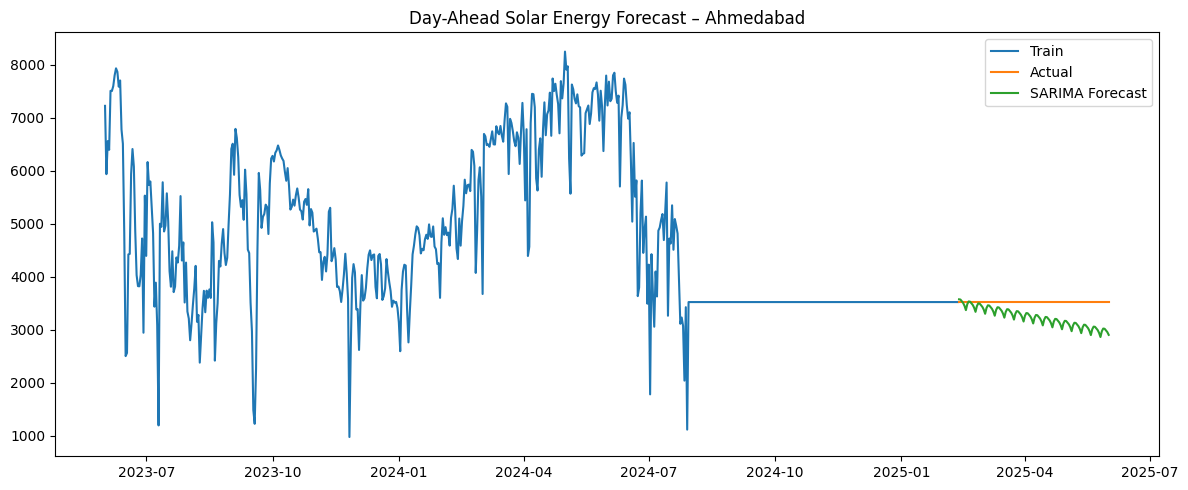

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast_mean, label="SARIMA Forecast")
plt.legend()
plt.title("Day-Ahead Solar Energy Forecast – Ahmedabad")
plt.tight_layout()
plt.show()


In [30]:
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
print("MAPE (%):", mape)


MAPE (%): 8.353886253595768
